# Explaining Tree Models with Interventional Feature Perturbation Tree SHAP

<div class="alert alert-info">
Note
    
To enable SHAP support, you may need to run
    
```bash
pip install alibi[shap]
```

</div>

## Introduction

This example shows how to apply interventional Tree SHAP to compute shap values exactly for an `xgboost` model fitted to the `Adult` dataset (binary classification task). Furthermore, the shap values computed by Kernel SHAP, an approximate feature attribution method, are shown to converge to the interventional Tree SHAP contributions given a sufficiently large number of model evaluations.

This example will use the [xgboost](https://github.com/dmlc/xgboost) library, which can be installed with:

In [1]:
!pip install -q xgboost

In [2]:
import json
import pickle
import shap
shap.initjs()

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from alibi.datasets import fetch_adult
from alibi.explainers import KernelShap, TreeShap
from collections import defaultdict, Counter
from functools import partial
from itertools import product, zip_longest

from scipy.special import expit
invlogit=expit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

from timeit import default_timer as timer

## Data preparation

### Load and split

The `fetch_adult` function returns a `Bunch` object containing features, targets, feature names and a mapping of categorical variables to numbers.

In [3]:
adult = fetch_adult()
adult.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'category_map'])

In [4]:
data = adult.data
target = adult.target
target_names = adult.target_names
feature_names = adult.feature_names
category_map = adult.category_map

Note that for your own datasets you can use the utility function `gen_category_map` imported from `alibi.utils`  to create the category map.

In [5]:
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, target])
data = data_perm[:,:-1]
target = data_perm[:,-1]

In [6]:
idx = 30000
X_train,y_train = data[:idx,:], target[:idx]
X_test, y_test = data[idx+1:,:], target[idx+1:]

`xgboost` wraps arrays using  `DMatrix` objects, optimised for both memory efficiency and training speed.

In [7]:
def wrap(arr):
    return np.ascontiguousarray(arr)

dtrain = xgb.DMatrix(
    wrap(X_train), 
    label=wrap(y_train), 
    feature_names=feature_names, 
)

dtest = xgb.DMatrix(wrap(X_test), label=wrap(y_test), feature_names=feature_names)

Finally, a matrix that contains the raw string values for categorical variables (used for display) is created:

In [8]:
def _decode_data(X, feature_names, category_map):
    """
    Given an encoded data matrix `X` returns a matrix where the 
    categorical levels have been replaced by human readable categories.
    """
    
    X_new = np.zeros(X.shape, dtype=object)
    for idx, name in enumerate(feature_names):
        categories = category_map.get(idx, None)
        if categories:
            for j, category in enumerate(categories):
                encoded_vals = X[:, idx] == j
                X_new[encoded_vals, idx] = category
        else:
            X_new[:, idx] = X[:, idx]
        
    return X_new
            
decode_data = partial(_decode_data,
                     feature_names=feature_names,
                     category_map=category_map)

In [9]:
X_display = decode_data(X_test)

In [10]:
X_display

array([[52, 'Private', 'Associates', ..., 0, 60, 'United-States'],
       [21, 'Private', 'High School grad', ..., 0, 20, 'United-States'],
       [43, 'Private', 'Dropout', ..., 0, 50, 'United-States'],
       ...,
       [23, 'Private', 'High School grad', ..., 0, 40, 'United-States'],
       [45, 'Local-gov', 'Doctorate', ..., 0, 45, 'United-States'],
       [25, 'Private', 'High School grad', ..., 0, 48, 'United-States']],
      dtype=object)

## Model definition

The model fitted in the `xgboost` fitting [example](xgboost_model_fitting_adult.ipynb) will be explained. The confusion matrix of this model is shown below.

In [11]:
def plot_conf_matrix(y_test, y_pred, class_names):
    """
    Plots confusion matrix. Taken from:
    http://queirozf.com/entries/visualizing-machine-learning-models-examples-with-scikit-learn-and-matplotlib
    """
    
    matrix = confusion_matrix(y_test,y_pred)


    # place labels at the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # plot the matrix per se
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # plot colorbar to the right
    plt.colorbar()

    fmt = 'd'

    # write the number of predictions in each bucket
    thresh = matrix.max() / 2.
    for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):

        # if background is dark, use a white number, and vice-versa
        plt.text(j, i, format(matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if matrix[i, j] > thresh else "black")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label',size=14)
    plt.xlabel('Predicted label',size=14)
    plt.show()

def predict(xgb_model, dataset, proba=False, threshold=0.5):
    """
    Predicts labels given a xgboost model that outputs raw logits. 
    """
    
    y_pred = model.predict(dataset)  # raw logits are predicted
    y_pred_proba = invlogit(y_pred) 
    if proba:
        return y_pred_proba
    y_pred_class = np.zeros_like(y_pred)
    y_pred_class[y_pred_proba >= threshold] = 1  # assign a label 
    
    return y_pred_class

In [12]:
model = xgb.Booster()  
model.load_model('assets/adult_xgb.mdl')

In [13]:
y_pred_train = predict(model, dtrain)
y_pred_test = predict(model, dtest)

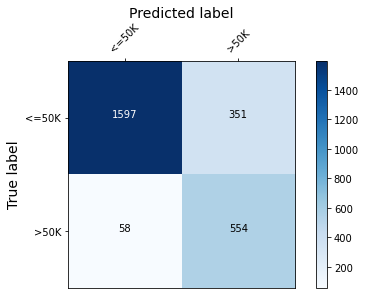

In [14]:
plot_conf_matrix(y_test, y_pred_test, target_names)

In [15]:
print(f'Train accuracy:  {round(100*accuracy_score(y_train, y_pred_train), 4)}  %.')
print(f'Test  accuracy:  {round(100*accuracy_score(y_test, y_pred_test), 4)}%.')

Train accuracy:  84.9333  %.
Test  accuracy:  84.0234%.


## Explaining xgboost with interventional Tree SHAP: global knowledge from local explanations

Recall that the goal of shap values computation for an instance $x$ is to attribute the difference $f(x) - \mathbb{E}_{\mathcal{D}}[f(x)]$ to $M$ input features. Here $\mathcal{D}$ represents the background data. Unlike the [path-dependent perturbation](path_dependent_tree_shap_adult_xgb.ipynb) algorithm which exploits the tree structure and cover information (derived from the training data) to obviate the need for a background dataset, the interventional perturbation algorithm follows a similar idea to [Kernel SHAP](https://docs.seldon.io/projects/alibi/en/stable/methods/KernelSHAP.html) and uses a background dataset to compute the expected value as the average of the leaves where the background samples fall plus the baseline model offset <sup>[(1)](#Footnotes) </sup> . As explained in the algorithm [overview](https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html), this allows explaining nonlinear transformations of the model output, so this method can be used to explain loss function fluctuations.

As discussed in [[1]](#References) and detailed in the [overview](https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html), this perturbation method enforces the conditional independence $x_{S} \perp x_{\bar{S}}$ where $\bar{S}$ is a subset of missing features. This section shows that this method is consistent with the path-dependent perturbation method, in the sense that it leads to very similar analysis conclusions assuming an appropriate background dataset is used.
<a id='source_3'></a>
<a id='f_3'></a>


Because the background dataset contains $30, 000$ examples, the next part of the example would be in principle a **long running**. In practice, sufficient accuracy can be achieved using a couple of hundred samples (the library authors recommend anywhere between 100 and 1000 examples), provided that the samples chosen represent the underlying distribution accurately (i.e., they cover the entire support of the distribution). You can skip the computation by setting `COMPUTE_SHAP = False` and can **load the results** by calling the `load_shap_values` function.

<div class="alert alert-warning">
Warning
    
Unfortunately, the current implementation of interventional `TreeShap` supports only up to 100 samples in the background dataset. Some of the issues related to this limitation have been reported [here](https://github.com/slundberg/shap/issues/2487) and [here](https://github.com/slundberg/shap/issues/1991). Thus, we will use only 100 background samples for the following experiments.
</div>

In [16]:
background_indices = np.random.choice(len(X_train), size=100, replace=False)
background_data = X_train[background_indices]

tree_explainer_interventional = TreeShap(model, model_output='raw', task='classification')  
tree_explainer_interventional.fit(background_data=background_data)

COMPUTE_SHAP = False  # whether to compute the SHAP values from scratch (the computation is quite fast).

if COMPUTE_SHAP:
    explanation = tree_explainer_interventional.explain(X_test)

    with open('assets/shap_interv.pkl', 'wb') as f:
        pickle.dump(explanation.shap_values[0], f)    

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


In [17]:
def load_shap_values():
    with open('assets/shap_interv.pkl', 'rb') as f:
        shap_interventional = pickle.load(f)
    
    return shap_interventional 

In [18]:
interventional_shap_values = load_shap_values()

Note that the local accuracy property holds for all examples.

In [19]:
errs = np.abs(model.predict(dtest) - tree_explainer_interventional.expected_value - interventional_shap_values.sum(1))
print(Counter(np.round(errs, 2)))

Counter({0.0: 2560})


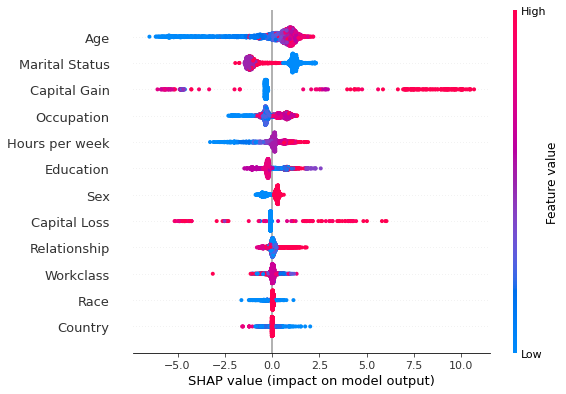

In [20]:
shap.summary_plot(interventional_shap_values, X_test, feature_names)

Figure 1: Summary plot of the interventional perturbation Tree SHAP explanations for the test set 
<a id='figure_8'></a>

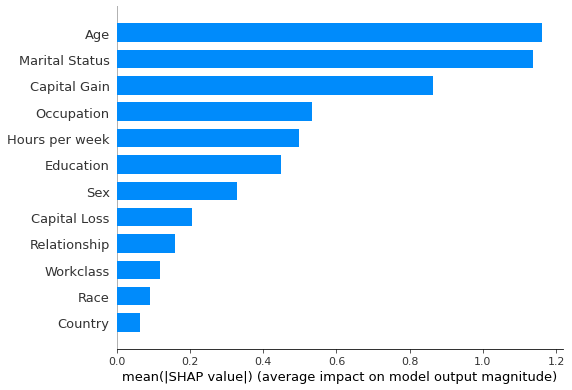

In [21]:
shap.summary_plot(interventional_shap_values, X_test, feature_names, plot_type='bar')

Figure 2: Most important features as predicted by the interventional perturbation Tree SHAP algorithm
<a id='figure_9'></a>

One might be tempted to proceed to compare the feature rankings displayed above with the ranking provided by the path-dependent Tree SHAP [example](path_dependent_tree_shap_adult_xgb.ipynb). However, these algorithms have different ways of estimating the effect of missing features and:

1. The length of the bar represents the average magnitude of the points in the summary plot above; each point is the average of the shap values computed for a given instance $x$ with respect to $R$ different background samples. Hence, one can consider that for each instance to be explained the shap value of the $j$th feature is a random variable, denoted by $\Phi_{i,j}$. One way to define the importance of the $j$th feature, $I_j$, is 

$$
I_j = \frac{1}{N} \sum \limits_{i=1}^N |\mathbb{E}[\Phi_{i, j}]|,
$$

where the expectation is taken over the background distribution and $N$ is the number of instances explained. This corresponds to the notion of feature importance according to which a feature is important for explaining the model behaviour over a given dataset if:

-  either the instances to explained are consistently affected by the feature, or the feature has a particularly large impact for certain subgroups and a small or moderate impact for the remainder. Traditional global explanation feature importances hide this information whereas the summary plot reveals why a particular feature was deemed important

- locally, one also requires that cancellation effects are not significant. In other words, for a particular instance, a feature would be considered as not important if, across different backgrounds, cancellation effects result in a small  average for the effect.

It should be noted that the error $I_j$ is inversely proportional to the square root of the size of the background dataset for a given dataset to be explained, so it is important to select a sufficient number of background samples in order to reduce the error of this estimate. 

2. The two methods explain the dataset with respect to different expected values, so the contributions will be different. This also arises because of the different set of conditional assumptions are made when estimating the individual contributions, as explained in the algorithm [overview](https://docs.seldon.io/projects/alibi/en/stable/methods/TreeSHAP.html).



Instead of analysing feature importance rankings, it is perhaps more instructive to look at the dependence plots and see if the conclusions from the previous model interpretation hold. Although the decision plots in Figure 3 show the same patterns as their counterparts in the path-dependent [example](path_dependent_tree_shap_adult_xgb.ipynb), different variables are found to have the strongest interaction with the variables of interest so the colouring of the plot is different. This is expected since the different conditional independence assumptions give rise to different magnitudes for the shap values, and therefore the estimations for the Pearson coefficients will be affected.  

In [22]:
def _dependence_plot(features, shap_values, dataset, feature_names, category_map, display_features=None, **kwargs):
    """ 
    Plots dependence plots of specified features in a grid.
    
    features: List[str], List[Tuple[str, str]]
        Names of features to be plotted. If List[str], then shap 
        values are plotted as a function of feature value, coloured 
        by the value of the feature determined to have the strongest
        interaction (empirically). If List[Tuple[str, str]], shap
        interaction values are plotted.
    display_features: np.ndarray, N x F
        Same as dataset, but contains human readable values
        for categorical levels as opposed to numerical values
    """
    
    def _set_fonts(fig, ax, fonts=None, set_cbar=False):
        """
        Sets fonts for axis labels and colobar.
        """

        ax.xaxis.label.set_size(xlabelfontsize)
        ax.yaxis.label.set_size(ylabelfontsize)
        ax.tick_params(axis='x', labelsize=xtickfontsize)
        ax.tick_params(axis='y', labelsize=ytickfontsize)
        if set_cbar:
            fig.axes[-1].tick_params(labelsize=cbartickfontsize)
            fig.axes[-1].tick_params(labelrotation=cbartickrotation)
            fig.axes[-1].yaxis.label.set_size(cbarlabelfontsize)

    # parse plotting args
    figsize = kwargs.get("figsize", (15, 10))
    nrows = kwargs.get('nrows', len(features))
    ncols = kwargs.get('ncols', 1)
    xlabelfontsize = kwargs.get('xlabelfontsize', 14)
    xtickfontsize = kwargs.get('xtickfontsize', 11)
    ylabelfontsize = kwargs.get('ylabelfontsize', 14)
    ytickfontsize = kwargs.get('ytickfontsize', 11)
    cbartickfontsize = kwargs.get('cbartickfontsize', 14)
    cbartickrotation = kwargs.get('cbartickrotation', 10)
    cbarlabelfontsize = kwargs.get('cbarlabelfontsize', 14)
    rotation_orig = kwargs.get('xticklabelrotation', 25)
    
    alpha = kwargs.get("alpha", 1)
    x_jitter_orig = kwargs.get("x_jitter", 0.8)
    grouped_features = list(zip_longest(*[iter(features)] * ncols))
    
    
    fig, axes = plt.subplots(nrows, ncols,  figsize=figsize)
    if nrows == len(features):
        axes = list(zip_longest(*[iter(axes)] * 1))


    for i, (row, group) in enumerate(zip(axes, grouped_features), start=1):
        # plot each feature or interaction in a subplot
        for ax, feature in zip(row, group):
            # set x-axis ticks and labels and x-jitter for categorical variables
            if not feature:
                continue
            if isinstance(feature, list) or isinstance(feature, tuple):
                feature_index = feature_names.index(feature[0])
            else:
                feature_index = feature_names.index(feature)
            if feature_index in category_map:
                ax.set_xticks(np.arange(len(category_map[feature_index])))
                if i == nrows:
                    rotation = 90
                else:
                    rotation = rotation_orig
                ax.set_xticklabels(category_map[feature_index], rotation=rotation, fontsize=22)
                x_jitter = x_jitter_orig
            else:
                x_jitter = 0
            
            shap.dependence_plot(feature, 
                                 shap_values,
                                 dataset,
                                 feature_names=feature_names,
                                 display_features=display_features,
                                 interaction_index='auto',
                                 ax=ax,
                                 show=False,
                                 x_jitter=x_jitter,
                                 alpha=alpha
                                )
            if i!= nrows:
                ax.tick_params('x', labelrotation=rotation_orig)
            _set_fonts(fig, ax, set_cbar=True)
    
plot_dependence = partial(
    _dependence_plot, 
    feature_names=feature_names,
    category_map=category_map,
)

<div class="alert alert-warning">
Warning
    
For the following plots to run the `matplotlib` version needs to be `<3.5.0`. This is because of an upstream issue of how the `shap.dependence_plot` function is handled in the `shap` library. An issue tracking it can be found [here](https://github.com/slundberg/shap/issues/2273).

</div>

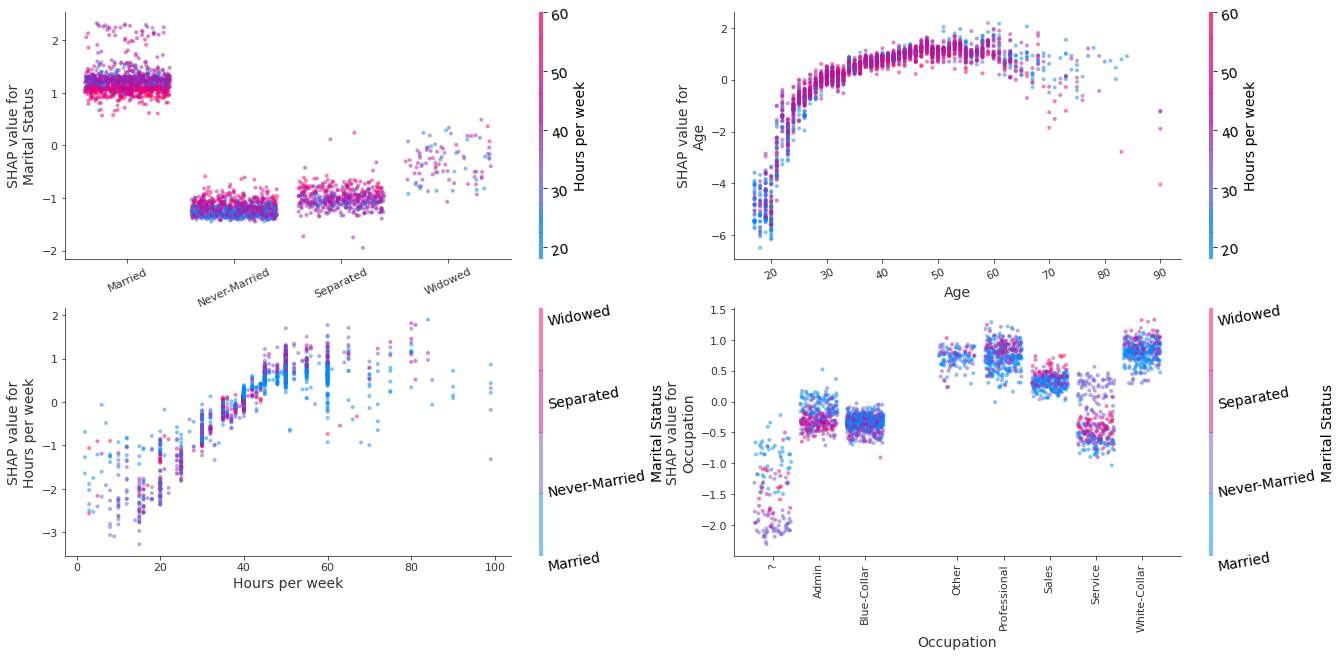

In [23]:
plot_dependence(['Marital Status', 'Age', 'Hours per week', 'Occupation'], 
                interventional_shap_values, 
                X_test, 
                display_features=X_display, 
                nrows=2,
                ncols=2,
                figsize=(22, 10),
                alpha=0.5)

Figure 3: Decision plots of the variables `Marital Status`, `Age`,  `Sex`, `Race`, `Occupation`, `Education` using the interventional perturbation Tree SHAP algorithm for the test set
<a id='figure_10'></a>

By changing, value of `feature` below, one can recolour the decision plots according to the interactions estimate from the path-dependent perturbation example. Generally, the same interaction patterns are observed, with the exception of `Age`, where the interaction with the `Capital Gain` feature is not conclusive.

In [24]:
path_dep_interactions = {
    'Marital Status': 'Hours per week',
    'Age': 'Capital Gain',
    'Hours per week': 'Age',
    'Occupation': 'Sex',
}

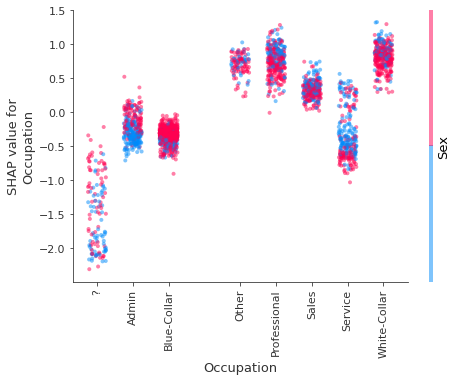

In [25]:
feature = 'Occupation'
x_jitter = 0.5 if feature in ['Occupation', 'Marital Status'] else 0
shap.dependence_plot(feature, 
                     interventional_shap_values,
                     X_test,
                     feature_names=feature_names,
                     display_features=X_display,
                     interaction_index=path_dep_interactions[feature],
                     alpha=0.5,
                     x_jitter=x_jitter
                    )

If interaction effects are of interest, these can be computed exactly using the path-dependent perturbation algorithm as opposed to approximated.

### White-box vs black-box model explanations: a comparison with Kernel SHAP 
<a id='convergence'></a>


The main drawback of model-agnostic methods such as [Kernel SHAP](https://docs.seldon.io/projects/alibi/en/stable/methods/KernelSHAP.html) is their sample complexity, which leads to variability in the results obtained. Given enough samples, the feature attributions estimated Kernel SHAP algorithm approach their exact values and give rise to the same feature importance rankings, as shown below.

Below, both the Tree SHAP and Kernel SHAP algorithms are used to explain `100` instances from the test set using a background  dataset of `100` samples (recall the background dataset size limitation of interventional TreeShap). For the Kernel SHAP algorithm, each explanation is computed `10` times to account for the variability in the estimation.

In [26]:
n_background_samples = 100  # same background dataset size limitation of interventional TreeShap 
n_explained = 100
background_dataset, y_background = resample(X_train, y_train, n_samples=n_background_samples, replace=False, random_state=0)

In [27]:
X_display_background = decode_data(background_dataset)
X_explain = X_test[:n_explained, :]

In [28]:
tree_explainer = TreeShap(model, model_output='raw', task='classification')
tree_explainer.fit(background_dataset)
explanation = tree_explainer.explain(X_explain)
tree_shap_values = explanation.shap_values[0]

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


`xgboost` requires the model inputs to be a `DMatrix` instance, so `predict_fcn` needs to account for this transformation to avoid errors.

In [29]:
predict_fcn = lambda x: model.predict(xgb.DMatrix(x, feature_names=feature_names))
kernel_explainer = KernelShap(predict_fcn)

In [30]:
kernel_explainer.fit(background_dataset)

Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            ,
  'version': '0.7.1dev'}
)

To assess convergence, Kernel SHAP is run with the numbers of samples specified in `n_samples` for `n_runs`. Since the computation is quite slow, you can skip the computation and can **load the precomputed results** by setting `COMPUTE_SHAP = False`.

In [31]:
n_runs = 5
n_samples = [64, 128, 512, 1024, 4096]  # there is no point going beyond 2^(num_features) = 2^12

In [32]:
COMPUTE_SHAP = False  # whether to compute the SHAP values from scratch (the computation is quite slow).

if COMPUTE_SHAP:
    results = defaultdict(list)
    times = defaultdict(list)

    for n_samp in n_samples:
        print(f"Number of samples {n_samp}")
        for run in range(n_runs):
            t_start = timer()
            exp = kernel_explainer.explain(X_explain, nsamples=n_samp, l1_reg=False)
            t_end = timer()
            times[str(n_samp)].append(t_end - t_start)
            results[str(n_samp)].append(exp.shap_values[0])

            results['time'] = times

            with open('assets/kernel_convergence.pkl', 'wb') as f:
                pickle.dump(results, f)

In [33]:
with open('assets/kernel_convergence.pkl', 'rb') as f:
    convergence_data = pickle.load(f)

To compare the two algorithms, the mean absolute deviation from the ground truth provided by the Tree SHAP algorithm with interventional feature perturbation is computed. For each number of samples, either the maximum mean absolute deviation across the feature, or the mean of this quantity across the features is computed. This calculation can be performed for one instance, or averaged across an entire distribution. The plots below show that all these quantities approach to the ground truth values. A threshold of $1\%$ from the effect of the most important feature (`Marital Status`) is depicted.

In [34]:
def get_errors(tree_shap_values, convergence_data, instance_idx=None):
    """
    Compute the mean and max maximum absolute deviation of Kernel SHAP values
    from Tree SHAP values for a specific instance or as an average over instances.
    If instance_idx is set, then the errors are computed at instance level.
    """
    
    mad = []
    for key in convergence_data:
        if key != 'time':
            mad.append(np.abs(tree_shap_values - np.mean(convergence_data[key], axis=0)))
    
    if instance_idx is not None:
        err_max = [max(x[instance_idx, :]) for x in mad]
        err_mean =[np.mean(x[instance_idx, :]).item() for x in mad]
    else:
        err_max = [max(x.mean(axis=0)) for x in mad]
        err_mean =[np.mean(x.mean(axis=0)).item() for x in mad]
    
    return err_max, err_mean 


def plot_convergence(err_mean, err_max, n_samples, threshold, instance_idx=None):
    """
    Plots the average error across the features and the maximum error across 
    features as a function of the number of samples Kernel SHAP uses to estimate
    the contributions. 
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.loglog(n_samples, err_max, '--*')
    ax1.plot([0] + n_samples, [threshold]*(len(n_samples)+1), '--', color='gray', linewidth='3')
    ax1.grid(True)
    ax1.set_ylabel('Estimation error (max over all features)')
    ax1.set_xlabel('Number of samples')
    
    ax2.loglog(n_samples, err_mean, '--*')
    ax2.plot([0] + n_samples, [threshold]*(len(n_samples)+1), '--', color='gray', linewidth='3')
    ax2.grid(True)
    ax2.set_ylabel('Estimation error (mean over all features)')
    ax2.set_xlabel('Number of samples')
    if instance_idx is not None:
        plt.suptitle(f'Convergence of the Kernel SHAP algorithm to exact shap values (instance {instance_idx})')
    else:
        plt.suptitle('Convergence of the Kernel SHAP algorithm to exact shap values (mean)')

In [35]:
threshold = 0.01 * np.max(np.mean(np.abs(tree_shap_values), axis=0))

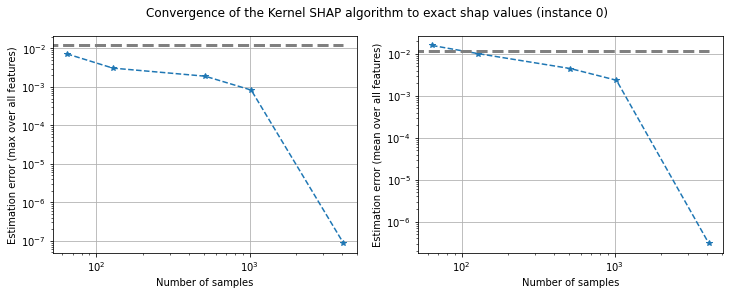

In [36]:
err_max, err_mean = get_errors(tree_shap_values, convergence_data, instance_idx=0)
plot_convergence(err_max, err_mean, n_samples, threshold, instance_idx=0)

Figure 4: Converge of Kernel SHAP to true values according to the maximum error (left) and mean error (right) for instance 0

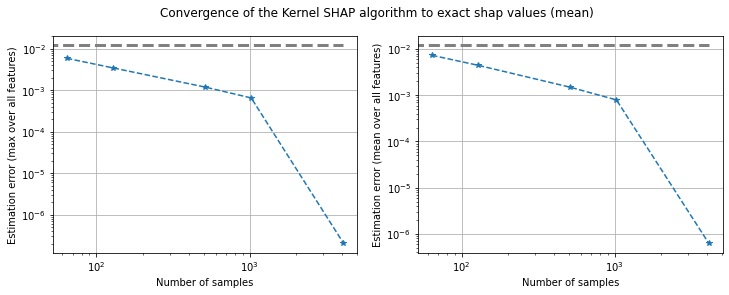

In [37]:
e_err_max, e_err_mean = get_errors(tree_shap_values, convergence_data)
plot_convergence(e_err_max, e_err_mean, n_samples, threshold)

Figure 5: Converge of Kernel SHAP according to the maximum error (left) and mean error (right) averaged across 100 instances

If a high enough number of samples is selected, the algorithms yield the same global patterns, as shown below.

In [38]:
n_explained = 500
X_explained = X_test[:n_explained, :]
explanation_500_kernel = kernel_explainer.explain(X_explained, nsamples=1024, l1_reg=False)
shap_values_500_kernel = explanation_500_kernel.shap_values[0]

  0%|          | 0/500 [00:00<?, ?it/s]

In [39]:
explanation_500_tree = tree_explainer.explain(X_explained)
shap_values_500_tree = explanation_500_tree.shap_values[0]

Again, we can observe that the local accuracy holds.

In [40]:
errs = np.round(np.abs(model.predict(xgb.DMatrix(X_explained, feature_names=feature_names)) - tree_explainer.expected_value - shap_values_500_tree.sum(1)), 2)
print(Counter(errs))

Counter({0.0: 500})


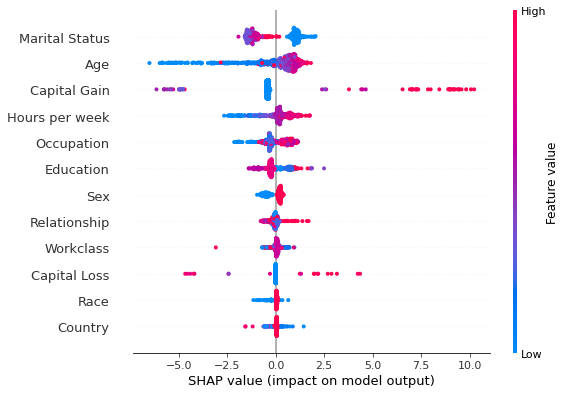

In [41]:
shap.summary_plot(shap_values_500_tree, X_explained, feature_names)

While the Tree SHAP values take a few seconds to compute, the Kernel SHAP takes a few minutes to provide estimates for the shap values. Note that this is also a consequence of the fact that the implementation of Tree SHAP is distributed.

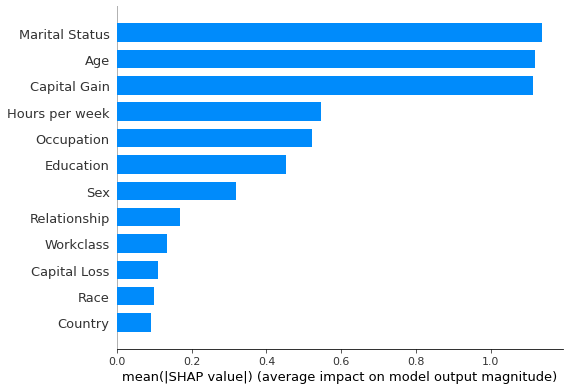

In [42]:
shap.summary_plot(shap_values_500_tree, X_explained, feature_names, plot_type='bar')

Figure 6: Feature importances estimated using the interventional feature perturbation Tree SHAP algorithm

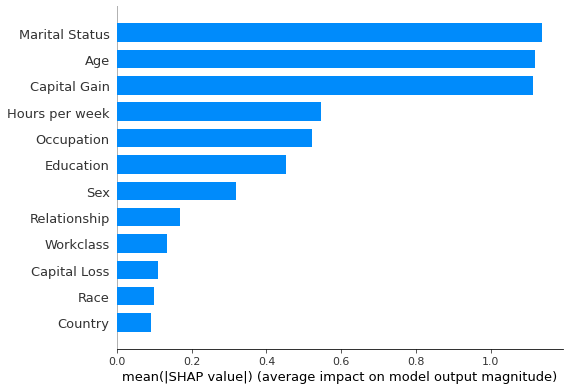

In [43]:
shap.summary_plot(shap_values_500_kernel, X_explained, feature_names, plot_type='bar')

Figure 7: Feature importances estimated using the Kernel SHAP algorithm

In [44]:
print(f"Max absolute deviation from ground truth: {np.round(np.max(np.abs(shap_values_500_tree - shap_values_500_kernel)), 4)}.")
print(f"Min absolute deviation from ground truth: {np.round(np.min(np.abs(shap_values_500_tree - shap_values_500_kernel)), 4)}.")

Max absolute deviation from ground truth: 0.0397.
Min absolute deviation from ground truth: 0.0.


Since the errors incurred in estimating the shap values are relatively small, the feature importance rankings shown in Figures 6 and 7 are identical.

In [45]:
average_prediction = model.predict(xgb.DMatrix(background_dataset, feature_names=feature_names)).mean()
kernel_exp_value = kernel_explainer.expected_value
tree_exp_value = tree_explainer.expected_value
print(f"Average prediction on background data is the expected value of kernel explainer: {np.abs(average_prediction - kernel_exp_value) < 1e-3}")
print(f"Average expected value for kernel explainer is the same as the tree explainer: {np.abs(kernel_exp_value - tree_exp_value) < 1e-3}")

Average prediction on background data is the expected value of kernel explainer: True
Average expected value for kernel explainer is the same as the tree explainer: True


The expected values of the two explainers are approximately the same.

In [46]:
print(f"The difference between the expected values is {np.round(np.abs(kernel_exp_value - tree_exp_value),2)}.")

The difference between the expected values is 0.0.


## References 

<a id='References'></a>

[[1]](#source_3) Lundberg, S.M., Erion, G., Chen, H., DeGrave, A., Prutkin, J.M., Nair, B., Katz, R., Himmelfarb, J., Bansal, N. and Lee, S.I., 2020. From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), pp.56-67.